In [6]:
!pip install --upgrade pip

In [1]:
## The goal is to implement ...
#!pip install supervisor==4.1.0
#!pip install feature-engine
!pip uninstall opencv-python -y
!pip install opencv-python
!pip uninstall opencv-python-headless -y
!pip install opencv-python-headless==4.3.0.38

Found existing installation: opencv-python 4.6.0.66
Uninstalling opencv-python-4.6.0.66:
  Successfully uninstalled opencv-python-4.6.0.66
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
  Using cached opencv-python-headless-4.3.0.38.tar.gz (88.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
anceled
ERROR: Operation cancelled by user


In [7]:
!pip install opencv-python-headless


  Using cached opencv_python_headless-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (48.3 MB)


In [8]:
#basic utils
import os

#importing torch framework
import torch
import torchvision
from torchvision import transforms

#visualization of data
import fiftyone as fo

#import models instance segmentation
#for boxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#for predicting masks
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

#handelling of coco formated dataset, such as the one we export from cvat
from pycocotools.coco import COCO

#for storing hardcoded input vars and hyperparams
from dataclasses import dataclass

#image handeling 
from PIL import Image

#simplify our training process and evaluation of model
from engine import train_one_epoch, evaluate
import utils

In [11]:
@dataclass
class Config:
    """ Holds all config hardcoded vars """
    data_path: str = "/home/joe/tinkering/cigs/detect_cigs/cig_butts/train/images" # The directory containing the source images
    ann_path: str = "/home/joe/tinkering/cigs/detect_cigs/cig_butts/train/annotations/coco_annotations.json" # The path to the COCO labels JSON file
    num_classes: int = 2 # background + cig
    epoches: int = 1
    batch_size: int = 2
    num_workers: int = 2

config = Config()


In [12]:
#Explore our data fiftyone to visualize our cocoformnated data

# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=config.data_path,
    labels_path=config.ann_path,
    label_types=["detections","segmentations"]
)

session = fo.launch_app(dataset)


 100% |███████████████| 2000/2000 [6.2s elapsed, 0s remaining, 350.8 samples/s]       
NumExpr defaulting to 4 threads.


## Build our dataset for input into pytorch dataloader

In [13]:

class CigDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_path, transforms=None):
        '''
        
        ARGS:
            dataset_dir is our root which contains both our images and our annotations json file
            split is train and test and corrosponds to the folders we hold in our dataset folder
            transforms is a preprocessing step including converting to tensors, augmentations ect
            
            Notice we are not loading in any mask dirs, as this mask information is encdoed in the cocoformat json 
            produced from exporting from CVAT.
            and therefore we generate masks from the polydata instead.
            
        '''
        
        self.annotations_path = annotations_path
        
        self.transforms = transforms 
        
        self.imgs_dir = images_dir
        
        self.coco = COCO(self.annotations_path)
        
        self.img_ids = self.coco.getImgIds()
        
    
    def __getitem__(self, indx):     # allows us to treat object instance of class as a data object
        
        '''
        returns:
        - PIL Image of shape (H, W)
        - target (dict) containing: 
            - boxes:    FloatTensor[N, 4], N being the n° of instances and it's bounding 
            boxe coordinates in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H;
            - labels:   Int64Tensor[N], class label (0 is background);
            - image_id: Int64Tensor[1], unique id for each image;
            - area:     Tensor[N], area of bbox;
            - iscrowd:  UInt8Tensor[N], True or False;
            - masks:    UInt8Tensor[N, H, W], segmantation maps;
        '''
        
        img_id = self.img_ids[indx]
        
        # load image and annotation info
        img_obj = self.coco.loadImgs(img_id)[0]
        anns_obj = self.coco.loadAnns(self.coco.getAnnIds(img_id))
        
        # get image
        img = Image.open(os.path.join(self.imgs_dir, img_obj['file_name']))
        
        # get masks
        masks = [self.coco.annToMask(ann) for ann in anns_obj]
        
        # get boxes
        #bboxes = [ann['bbox'] for ann in anns_obj]
        
        num_objs = len(anns_obj)
        
        #coco format[xmin, ymin, width, height]
        #pytorch [xmin, ymin, xmax, ymax]
        bboxes = []
        for i in range(num_objs):
            xmin = anns_obj[i]['bbox'][0]
            ymin = anns_obj[i]['bbox'][1]
            xmax = xmin + anns_obj[i]['bbox'][2]
            ymax = ymin + anns_obj[i]['bbox'][3]
            bboxes.append([xmin, ymin, xmax, ymax])
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        
        
        #get bbox area size
        areas = [ann['area'] for ann in anns_obj]
        
        # convert to tensors as per the coco requiresments
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.ones(len(anns_obj), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.as_tensor(img_id, dtype=torch.int64) #torch.as_tensor([indx])
        areas = torch.as_tensor(areas)
        iscrowd = torch.zeros(len(anns_obj), dtype=torch.int64)
        
        print(f'im id {image_id}')
        
        target = {}
        target["image_id"] = image_id # this is the ID associated to our image
        target["masks"] = masks # these are are segmentations produced when we converted the polygon info into masks
        target["boxes"] = bboxes # bounding box that encapsulates object instance
        target["area"] = areas # area of the bounding box
        target["labels"] = labels # this is what we are identifying. might be cats, or cats and dogs. background is always class 0
        target["iscrowd"] = iscrowd # determines target type: iscrowd = 0 uses polygons for the object instances, while iscrowd = 1 uses run-length encoding (RLE).
        
        if self.transforms is not None:
            img = self.transforms(img)
            #target = self.transforms(target)
        
        return img, target
    
    def __len__(self):
        return len(self.img_ids)
    

### Mask R-CNN instance segmenation model

will be using Mask R-CNN, which is based on top of Faster R-CNN. Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

In [14]:
def get_model_instance_segmentation(num_classes):
    '''
    Fine-tune from a pre-trained model
    '''
    
    # load pretrained instance segmentation model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for fastrcnn classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
        
    # replace the maskrcnn box predictor with fastrcnn box predictor
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
       
    # get number of features for mask classifier 
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256 
    
    # replace mask predictor with new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    
    return model


def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    custom_transforms.append(torchvision.transforms.RandomHorizontalFlip(0.5))
    return torchvision.transforms.Compose(custom_transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

### Test our forward pass

In [15]:
dataset = CigDataset(images_dir=config.data_path, annotations_path=config.ann_path, transforms=get_transform())

print(type(dataset[0])) #tuple
print(dataset[0][1].keys()) # annotations
print(len(dataset[0][1]['masks'][0])) #mask tensor
#dataset[0][0] #image

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
im id 0
<class 'tuple'>
im id 0
dict_keys(['image_id', 'masks', 'boxes', 'area', 'labels', 'iscrowd'])
im id 0
512


/tmp/ipykernel_9953/4252175252.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


In [16]:
# create instance of model
model = get_model_instance_segmentation(config.num_classes)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

# For Training
images,targets = next(iter(data_loader))

images = list(image for image in images)

targets = [{k: v for k, v in t.items()} for t in targets]

output = model(images,targets)   # Returns losses and detections

im id 353
im id 1871im id 1400

im id 1697
im id 1982
im id 142
im id 1899im id 345

im id 1214
im id 137
im id 1888
im id 204
im id 1211
im id 1221
im id 475
im id 1419


In [17]:
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

# print(type(predictions))
# print(len(predictions))
# print(predictions[0])

In [18]:
output.keys()
print(output)

{'loss_classifier': tensor(0.8307, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1291, grad_fn=<DivBackward0>), 'loss_mask': tensor(4.0082, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.0026, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0024, grad_fn=<DivBackward0>)}


In [19]:
def main():
    
    #get params
    config = Config()
    
    #GPU or CPU
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    
    # retrieve datasets
    dataset_train = CigDataset(images_dir=config.data_path, annotations_path=config.ann_path, transforms=get_transform())
    dataset_test = CigDataset(images_dir=config.data_path, annotations_path=config.ann_path, transforms=get_transform())
    
    # split test and train
    #indices = torch.randperm(len(dataset_train)).tolist()
    indices = torch.randperm(10).tolist()
    dataset_train = torch.utils.data.Subset(dataset_train, indices[:8])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[8:10])
    
    print(len(dataset_train))
    print(len(dataset_test))
    
    # load data
    data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, collate_fn=collate_fn)
    data_loader_test = torch.utils.data.DataLoader(dataset_test, config.batch_size, shuffle=False, num_workers=config.num_workers, collate_fn=collate_fn)
    
    # get model instance
    model = get_model_instance_segmentation(config.num_classes)
    
    # push model to device
    model.to(device)
    
    # construct optimizer 
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    # learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    # training loop
    for epoch in range(config.epoches):
        
        # train epoch
        train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1)
        
        # update learning rate
        lr_scheduler.step()
        
        # evaluate on test set
        evaluate(model, data_loader_test, device=device)
        
        
main()
    
    

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
8
2
im id 3im id 4

im id 1
im id 0
im id 6im id 8

im id 9
im id 5


/home/joe/anaconda3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [0]  [0/4]  eta: 0:01:28  lr: 0.001670  loss: 5.0360 (5.0360)  loss_classifier: 0.7005 (0.7005)  loss_box_reg: 0.0633 (0.0633)  loss_mask: 3.9950 (3.9950)  loss_objectness: 0.2575 (0.2575)  loss_rpn_box_reg: 0.0197 (0.0197)  time: 22.1888  data: 0.2753
Epoch: [0]  [1/4]  eta: 0:01:06  lr: 0.003335  loss: 3.3770 (4.2065)  loss_classifier: 0.7005 (0.7025)  loss_box_reg: 0.0633 (0.0888)  loss_mask: 2.5549 (3.2749)  loss_objectness: 0.0013 (0.1294)  loss_rpn_box_reg: 0.0021 (0.0109)  time: 22.1917  data: 0.1377
Epoch: [0]  [2/4]  eta: 0:00:48  lr: 0.005000  loss: 3.3770 (3.2400)  loss_classifier: 0.7005 (0.5495)  loss_box_reg: 0.1142 (0.0979)  loss_mask: 2.5549 (2.4905)  loss_objectness: 0.0254 (0.0947)  loss_rpn_box_reg: 0.0021 (0.0074)  time: 24.2083  data: 0.0951
Epoch: [0]  [3/4]  eta: 0:00:24  lr: 0.005000  loss: 2.4297 (3.0375)  loss_classifier: 0.2436 (0.4303)  loss_box_reg: 0.0683 (0.0905)  loss_mask: 2.2448 (2.4290)  loss_objectness: 0.0254 (0.0814)  loss_rpn_box_reg: 0.002

im id 722
im id 723
im id 724
im id 725
im id 726
im id 727
im id 728
im id 729
im id 730
im id 731
im id 732
im id 733
im id 734
im id 735
im id 736
im id 737
im id 738
im id 739
im id 740
im id 741
im id 742
im id 743
im id 744
im id 745
im id 746
im id 747
im id 748
im id 749
im id 750
im id 751
im id 752
im id 753
im id 754
im id 755
im id 756
im id 757
im id 758
im id 759
im id 760
im id 761
im id 762
im id 763
im id 764
im id 765
im id 766
im id 767
im id 768
im id 769
im id 770
im id 771
im id 772
im id 773
im id 774
im id 775
im id 776
im id 777
im id 778
im id 779
im id 780
im id 781
im id 782
im id 783
im id 784
im id 785
im id 786
im id 787
im id 788
im id 789
im id 790
im id 791
im id 792
im id 793
im id 794
im id 795
im id 796
im id 797
im id 798
im id 799
im id 800
im id 801
im id 802
im id 803
im id 804
im id 805
im id 806
im id 807
im id 808
im id 809
im id 810
im id 811
im id 812
im id 813
im id 814
im id 815
im id 816
im id 817
im id 818
im id 819
im id 820
im id 821


im id 1498
im id 1499
im id 1500
im id 1501
im id 1502
im id 1503
im id 1504
im id 1505
im id 1506
im id 1507
im id 1508
im id 1509
im id 1510
im id 1511
im id 1512
im id 1513
im id 1514
im id 1515
im id 1516
im id 1517
im id 1518
im id 1519
im id 1520
im id 1521
im id 1522
im id 1523
im id 1524
im id 1525
im id 1526
im id 1527
im id 1528
im id 1529
im id 1530
im id 1531
im id 1532
im id 1533
im id 1534
im id 1535
im id 1536
im id 1537
im id 1538
im id 1539
im id 1540
im id 1541
im id 1542
im id 1543
im id 1544
im id 1545
im id 1546
im id 1547
im id 1548
im id 1549
im id 1550
im id 1551
im id 1552
im id 1553
im id 1554
im id 1555
im id 1556
im id 1557
im id 1558
im id 1559
im id 1560
im id 1561
im id 1562
im id 1563
im id 1564
im id 1565
im id 1566
im id 1567
im id 1568
im id 1569
im id 1570
im id 1571
im id 1572
im id 1573
im id 1574
im id 1575
im id 1576
im id 1577
im id 1578
im id 1579
im id 1580
im id 1581
im id 1582
im id 1583
im id 1584
im id 1585
im id 1586
im id 1587
im id 1588

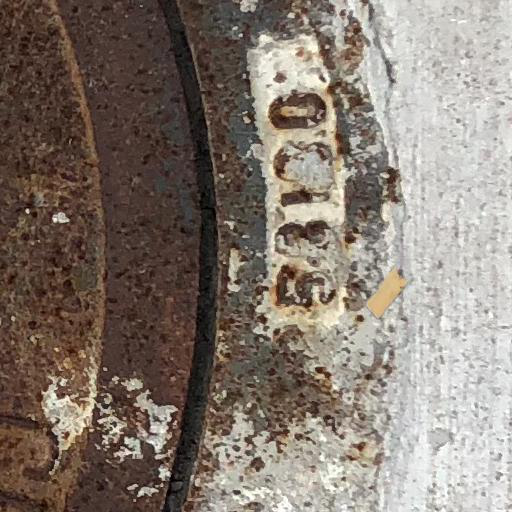

In [20]:
img_path = "/home/joe/tinkering/cigs/detect_cigs/cig_butts/train/images/00000002.jpg"


img = Image.open(img_path)

def pred_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

t = pred_transform()

predictions = model([t(img)])

img

In [7]:
!pip install opencv-python==3.4.11.41
!pip install opencv-contrib-python==3.4.11.45

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:02m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for opencv-python (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1710 lines of output]
      Not searching for unused variables given on the command line.
      CMake Error: CMake was unable to find a build program corresponding to "Ninja".  CMAKE_MAKE_PROGRAM is not set.  You probably need to select a different build tool.
      -- Configuring incomplete, errors occurred!
      See also "/tmp/pip-install-8py6w7qp/opencv-python_3aad8b41f7d04e3ab1a619604eb73e50/_cmake_test_compile/build/CMakeFiles/CMakeOutput.log".
      Not searching for unused variables given on the command line.
      -- The C compiler identification is GNU 11.2.0
      -- Detecting C compiler ABI info
    

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 202.8 kB/s eta 0:00:00m eta 0:00:010:00:08


In [8]:
import cv2
img_path = "/home/joe/tinkering/cigs/detect_cigs/cig_butts/train/images/00000002.jpg"

img = cv2.imread(img_path,1)

#img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)

cv2.imshow('image', img)



# for i in range(len(predictions[0]['boxes'])):
#     x1, x2, x3, x4 = map(int, predictions[0]['boxes'][i].tolist())
#     #print(x1, x2, x3, x4)
#     image = cv2.rectangle(img, (x1, x2), (x3, x4), (255, 0, 0), 1)
# cv2.imshow(img, image)

error: OpenCV(4.6.0) /io/opencv/modules/highgui/src/window.cpp:1267: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [ ]:
print(len(predictions))
print(type(predictions[0]))
print(predictions[0].keys())
print(len(predictions[0]['masks']))
l
# dataset_train = CigDataset(images_dir=config.data_path, annotations_path=config.ann_path, transforms=get_transform())
# dataset_test = CigDataset(images_dir=config.data_path, annotations_path=config.ann_path, transforms=get_transform())

# # split test and train
# indices = torch.randperm(len(dataset_train)).tolist()
# print(indices)

# if 0 in indices:
#     print(True) 